In [1]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils import read_lastfm, build_vocab, load_model, get_embeddings
from gensim.models import Word2Vec

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, make_scorer
from sklearn.dummy import DummyClassifier

In [108]:
songs, users = read_lastfm(zip_name="data/lastfm-dataset-1K.zip")

In [109]:
songs["song_id"]= songs.artist_name.cat.codes.astype("int64") * songs.track_name.nunique() \
                            + songs.track_name.cat.codes

# Song2vec loading

In [ ]:
LOAD = True

In [5]:
if LOAD:
    emb_vectors, model = load_model("data/word2vec/108.model")
else:
    kwargs_108 = {'vector_size': 100, 'window': 3, 'min_count': 1, 'negative': 5, 'ns_exponent': -0.8}
    sample, emb_vectors, model = get_embeddings(songs, **kwargs_108)
    model.save("data/word2vec/108.model")

In [7]:
len(emb_vectors.keys())

1498723

In [8]:
s2v_df = pd.DataFrame(data=list(emb_vectors.values()), index=list(emb_vectors.keys()))

# TF-IDF initialization

In [9]:
corpus_df = songs.sort_values(["user_id", "timestamp"]).groupby("user_id")\
                .agg(sequence=("song_id", list))

In [10]:
corpus = corpus_df.values[:,0]

In [11]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
X = vectorizer.fit_transform(corpus)

In [12]:
song_ids = list(vectorizer.vocabulary_.keys())
indices = list(vectorizer.vocabulary_.values())

In [13]:
song_ids = [x for _,x in sorted(zip(indices,song_ids))]

In [14]:
tfidf_df = pd.DataFrame(data=X.T.todense(), index=song_ids)

# Classification Tasks

* Predict if two songs appear in the same context
* Predict if two songs are from the same artist
* Predict the artist of a song
* Predict the tag of a song

In [15]:
SEED = 42

In [16]:
def compute_metrics(y_test, y_pred, y_proba, multi=False):
    acc = accuracy_score(y_test, y_pred)
    if not multi:
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)
        return acc, f1, auc
    else:
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred)
        return acc, f1, cm

In [17]:
def predict_RF(X_train, X_test, y_train, y_test, scoring='f1', multi=False,
               param_grid = {'n_estimators': [50, 100, 150],
                            'criterion': ['gini', 'entropy']}):
    model = RandomForestClassifier(random_state=SEED)
    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    grid = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, verbose=4)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    print(f"Best parameters are: {grid.best_params_}")
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:,1]
    return compute_metrics(y_test, y_pred, y_proba, multi=multi), grid.cv_results_['std_test_score']


In [18]:
def predict_random(X_train, y_train, X_test, y_test, multi=False):
    random = DummyClassifier(strategy='uniform', random_state=SEED)
    random.fit(X_train, y_train)
    y_pred = random.predict(X_test)
    y_proba = random.predict_proba(X_test)[:, 1]
    return compute_metrics(y_test, y_pred, y_proba, multi=multi)

def predict_majority(X_train, y_train, X_test, y_test, multi=False):
    majority = DummyClassifier(strategy='most_frequent', random_state=SEED)
    majority.fit(X_train, y_train)
    y_pred = majority.predict(X_test)
    y_proba = majority.predict_proba(X_test)[:, 1]
    return compute_metrics(y_test, y_pred, y_proba, multi=multi)

In [19]:
def create_vectors_pairs(vectors, song_pairs):
    vector_pairs = vectors.merge(song_pairs, right_on="song1", left_index=True)\
            .merge(vectors, left_on="song2", right_index=True)\
            .drop(['song1', 'song2'], axis=1)
    print(len(vector_pairs))
    print(len(song_pairs))
    assert len(vector_pairs) == len(song_pairs)
    assert vector_pairs.shape[1] == vectors.shape[1] * 2
    return vector_pairs

In [20]:
def plot_metrics(f1_s2v, std_s2v, f1_tfidf, std_tfidf, title, multi=False):
    plt.figure(figsize=(10,5))
    acc_rand, f1_rand, auc_rand = predict_random(X_train, y_train, X_test, y_test, multi=multi)
    acc_maj, f1_maj, auc_maj = predict_majority(X_train, y_train, X_test, y_test, multi=multi)
    x = range(4)
    y = [f1_s2v, f1_tfidf, f1_rand, f1_maj]
    yerr = np.array([np.mean(std_s2v)/2, np.mean(std_tfidf)/2, 0, 0])
    plt.bar(x, y, yerr=[yerr, yerr], width=0.8,
        color='#90D8D3',
        edgecolor='k',
        capsize=5)
    plt.xticks(x, ['Song2Vec', 'tfidf', 'random', 'majority'])
    plt.ylabel("F1 score")
    plt.title(title)
    plt.show()

## Same context classification

In [77]:
sorted_songs = songs.sort_values(["user_id", "timestamp"])

In [78]:
def pick_song_in_same_context(songs, half_n):
    """Simply chooses random songs pair them with the previous or following one"""
    np.random.seed(SEED)
    idx1 = np.random.randint(1, len(songs) - 1, half_n) #Exclude first and last song
    idx2 = idx1.copy() #Offset the first index by -1 or 1 
    idx2[::2] += 1
    idx2[1::2] -= 1
    songs1 = songs.iloc[idx1].song_id.values
    songs2 = songs.iloc[idx2].song_id.values
    X = np.c_[songs1, songs2]
    y = np.ones(half_n)
    return X, y
    
def pick_songs_in_diff_context(songs, half_n):
    songs1 = songs.sample(half_n, random_state=SEED).song_id.values
    songs2 = songs.sample(half_n, random_state=SEED + 1).song_id.values
    X = np.c_[songs1, songs2]
    y = np.zeros(half_n)
    return X, y

def create_context_dataset(sorted_songs, n=20000):
    """Create a dataset of song pairs that either appeared in the same context or not""" 
    X_pos, y_pos = pick_song_in_same_context(sorted_songs, n//2)
    X_neg, y_neg = pick_songs_in_diff_context(sorted_songs, n//2)
    old_X = np.r_[X_pos, X_neg]
    old_y = np.r_[y_pos, y_neg]
    dataset = list(zip(old_X, old_y))
    np.random.seed(SEED)
    np.random.shuffle(dataset)
    X, y = zip(*dataset)
    return pd.DataFrame(X, columns=["song1", "song2"]), np.array(y)

In [79]:
song_pairs, labels = create_context_dataset(sorted_songs, n= 20000)

In [80]:
#Only keep song with s2v embeddings
song_pairs = song_pairs.copy()
song_pairs['labels'] = labels
song_pairs = song_pairs[song_pairs.song1.isin(s2v_df.index) & song_pairs.song2.isin(s2v_df.index)]
labels = song_pairs.labels
song_pairs.drop('labels', axis=1, inplace=True)

### TF-IDF

In [81]:
tfidf_pairs = create_vectors_pairs(tfidf_df, song_pairs)

20000
20000


In [82]:
tfidf_pairs.head()

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,982_y,983_y,984_y,985_y,986_y,987_y,988_y,989_y,990_y,991_y
6668,0.0,0.0,0.0,0.009143,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003974,0.0,0.0,0.002027,0.0,0.0,0.0,0.0,0.0,0.0
6477,0.0,0.0,0.0,0.005735,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5930,0.0,0.0,0.0,0.005569,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
12585,0.0,0.0,0.0,0.005569,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3939,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
X_train, X_test, y_train, y_test = \
                train_test_split(tfidf_pairs, labels, train_size=0.8, random_state=SEED)
(acc, f1_tfidf, auc), std_tfidf = predict_RF(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=  16.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=  15.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=  14.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=  14.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=  14.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=  27.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=  26.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=  26.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=  27.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=  26.7s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=  40.1s
[CV 2/5] END ...............criterion=gini, n_est

In [84]:
print("TF-IDF:", acc, f1_tfidf, auc)
print("Random:", predict_random(X_train, y_train, X_test, y_test))
print("Majority:",predict_majority(X_train, y_train, X_test, y_test))

TF-IDF: 0.49825 0.4950943396226415 0.49838703019158237
Random: (0.4995, 0.5071393402264894, 0.5)
Majority: (0.48625, 0.0, 0.5)


### song2vec

In [85]:
s2v_pairs = create_vectors_pairs(s2v_df, song_pairs)

20000
20000


In [86]:
s2v_pairs.head()

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,90_y,91_y,92_y,93_y,94_y,95_y,96_y,97_y,98_y,99_y
2272,0.062533,2.646188,1.771240,0.356027,3.483881,-0.590848,-2.429225,2.533570,-1.950409,3.880151,...,2.025337,-0.535605,-1.385405,0.637838,-0.338939,0.108875,-0.748792,-0.611265,-1.193499,0.673004
18664,-0.008902,1.077724,0.709782,0.166642,1.394907,-0.192730,-1.005193,0.967549,-0.752923,1.564130,...,2.025337,-0.535605,-1.385405,0.637838,-0.338939,0.108875,-0.748792,-0.611265,-1.193499,0.673004
2486,0.062533,2.646188,1.771240,0.356027,3.483881,-0.590848,-2.429225,2.533570,-1.950409,3.880151,...,0.036377,-0.015997,-0.035529,0.007756,-0.003772,0.004609,-0.021812,-0.006417,-0.034017,0.011343
9275,0.062533,2.646188,1.771240,0.356027,3.483881,-0.590848,-2.429225,2.533570,-1.950409,3.880151,...,1.042502,-0.275264,-0.699596,0.331668,-0.177756,0.048686,-0.375654,-0.306628,-0.620744,0.347940
11186,0.062533,2.646188,1.771240,0.356027,3.483881,-0.590848,-2.429225,2.533570,-1.950409,3.880151,...,4.721431,-1.248810,-3.138873,1.458313,-0.764569,0.319603,-1.742567,-1.457467,-2.820880,1.586536


In [87]:
X_train, X_test, y_train, y_test = \
                train_test_split(s2v_pairs, labels, train_size=0.8, random_state=SEED)
(acc, f1_s2v, auc), std_s2v = predict_RF(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=  17.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=  14.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=  15.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=  16.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=  13.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=  33.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=  31.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=  31.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=  30.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=  28.1s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=  48.2s
[CV 2/5] END ...............criterion=gini, n_est

In [88]:
print("Song2Vec:", acc, f1_s2v, auc)

Song2Vec: 0.49375 0.4736158045230049 0.49827807279254943


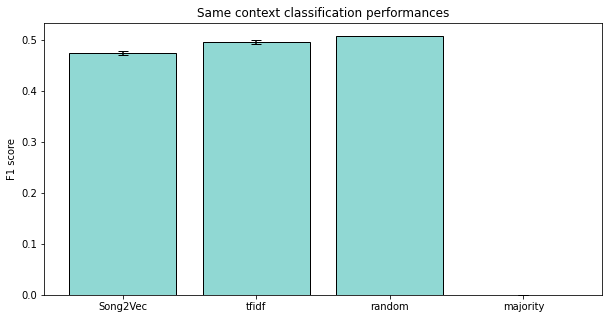

In [89]:
plot_metrics(f1_s2v, std_s2v, f1_tfidf, std_tfidf, "Same context classification performances")

## Same artist classification

In [90]:
discography = songs[["artist_name", "track_name", "song_id"]].drop_duplicates()

In [91]:
def pick_songs_from_same_artist(discography, half_n):
    """Simply chooses random songs pair them with the previous or following one"""
    artist_with_multiple_songs = discography.groupby("artist_name")\
                                .agg(count=("track_name", "count")).reset_index()
    discography = discography.merge(artist_with_multiple_songs)
    
    song_pairs = discography.groupby("artist_name").agg(song1=("song_id", "first"), 
                                                        song2=("song_id", "last"))
    X = song_pairs.sample(half_n, random_state=SEED).values
    y = np.ones(half_n)
    return X, y
    
def pick_songs_from_diff_artist(discography, half_n):
    discography = discography.drop_duplicates("artist_name")
    random_songs = discography.sample(2*half_n, random_state=SEED).song_id.values
    songs1 = random_songs[:half_n]
    songs2 = random_songs[half_n:]
    X = np.c_[songs1, songs2]
    y = np.zeros(half_n)
    return X, y

def create_artist_dataset(discography, n=20000):
    """Create a dataset of song pairs that either appeared in the same context or not""" 
    discography = discography.merge(s2v_df, left_on="song_id", right_index=True)
    discography = discography.merge(tfidf_df, left_on="song_id", right_index=True)
    X_pos, y_pos = pick_songs_from_same_artist(discography, n//2)
    X_neg, y_neg = pick_songs_from_diff_artist(discography, n//2)
    old_X = np.r_[X_pos, X_neg]
    old_y = np.r_[y_pos, y_neg]
    dataset = list(zip(old_X, old_y))
    np.random.seed(SEED)
    np.random.shuffle(dataset)
    X, y = zip(*dataset)
    return pd.DataFrame(X, columns=["song1", "song2"]), np.array(y)

In [92]:
song_pairs, labels = create_artist_dataset(discography, 20000)

In [93]:
#Only keep song with s2v embeddings
song_pairs = song_pairs.copy()
song_pairs['labels'] = labels
song_pairs = song_pairs[song_pairs.song1.isin(s2v_df.index) & song_pairs.song2.isin(s2v_df.index)]
song_pairs = song_pairs[song_pairs.song1.isin(tfidf_df.index) & song_pairs.song2.isin(tfidf_df.index)]
labels = song_pairs.labels
# song_pairs.drop('labels', axis=1, inplace=True)

In [94]:
song_pairs_neg = song_pairs.query("labels == 0").iloc[:3547]
song_pairs_pos = song_pairs.query("labels == 1")

In [95]:
song_pairs = pd.concat([song_pairs_neg, song_pairs_pos])
labels = song_pairs.labels
song_pairs.drop('labels', axis=1, inplace=True)

### TF-IDF

In [96]:
tfidf_pairs = create_vectors_pairs(tfidf_df, song_pairs)

13547
13547


In [97]:
X_train, X_test, y_train, y_test = \
                train_test_split(tfidf_pairs, labels, train_size=0.8, random_state=SEED)
(acc, f1_tfdf, auc), std_tfidf = predict_RF(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   8.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   8.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   7.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   8.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   7.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=  13.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=  13.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=  13.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=  13.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=  13.7s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=  20.0s
[CV 2/5] END ...............criterion=gini, n_est

In [98]:
print("TF-IDF:", acc, f1_tfidf, auc)

TF-IDF: 0.992619926199262 0.4950943396226415 0.9969587937082043


### Song2vec

In [99]:
s2v_pairs = create_vectors_pairs(s2v_df, song_pairs)

13547
13547


In [100]:
X_train, X_test, y_train, y_test = \
                train_test_split(s2v_pairs, labels, train_size=0.8, random_state=SEED)
(acc, f1_s2v, auc), std_s2v = predict_RF(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   7.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   7.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   7.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   7.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   7.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=  14.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=  14.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=  14.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=  13.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=  14.4s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=  21.3s
[CV 2/5] END ...............criterion=gini, n_est

In [101]:
print("Song2Vec:", acc, f1_s2v, auc)

Song2Vec: 0.8472324723247232 0.9033162073797292 0.7954992374361427


In [102]:
print("Random:", predict_random(X_train, y_train, X_test, y_test))
print("Majority:",predict_majority(X_train, y_train, X_test, y_test))

Random: (0.5180811808118081, 0.6075721153846154, 0.5)
Majority: (0.733210332103321, 0.8460719608260592, 0.5)


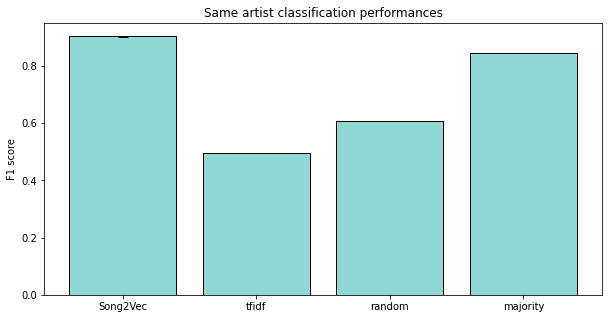

In [103]:
plot_metrics(f1_s2v, std_s2v, f1_tfidf, std_tfidf, "Same artist classification performances")

## Top artists classification

In [106]:
def create_top_artist_dataset(df, top_n=10):
    top_artist = df[df.song_id.isin(emb_vectors.keys())].artist_name.value_counts()\
        .to_frame().head(top_n).reset_index()['index']
    top_artist_codes = list(top_artist.cat.codes)
    top_artist = list(top_artist)
    top_df = songs[songs.artist_name.cat.codes.isin(top_artist_codes)].drop_duplicates('song_id').copy()
    mapping = {artist: top_artist.index(artist) for artist in top_artist}
    top_df['label'] = top_df.artist_name.map(mapping)
    top_df = top_df[['song_id', 'label']]
    top_df = top_df[top_df.song_id.isin(s2v_df.index) & top_df.song_id.isin(tfidf_df.index)]
    return top_df

In [110]:
top_artist_songs = create_top_artist_dataset(songs, top_n=30)
len(top_artist_songs)

19237

In [111]:
param_grid = {'n_estimators': [50, 100, 150], #2,900, 1000, 
            'criterion': ['gini', 'entropy'], #, 
            'class_weight':['balanced']}
scorer = make_scorer(f1_score, average='weighted')

### TF-IDF

In [112]:
tfidf_top_artist = tfidf_df.merge(top_artist_songs, left_index=True, right_on='song_id')
assert len(top_artist_songs) == len(tfidf_top_artist)
X_tfidf = tfidf_top_artist.drop(['song_id', 'label'], axis=1)
y_tfidf = tfidf_top_artist.label.values.astype(int)

In [113]:
X_train, X_test, y_train, y_test = \
                train_test_split(X_tfidf, y_tfidf, train_size=0.8, random_state=SEED)

(acc, f1_tfidf, cm), std_tfidf = predict_RF(X_train, X_test, y_train, y_test, param_grid=param_grid, scoring=scorer, multi=True)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END class_weight=balanced, criterion=gini, n_estimators=50; total time=  10.6s
[CV 2/5] END class_weight=balanced, criterion=gini, n_estimators=50; total time=  10.6s
[CV 3/5] END class_weight=balanced, criterion=gini, n_estimators=50; total time=  13.4s
[CV 4/5] END class_weight=balanced, criterion=gini, n_estimators=50; total time=  12.7s
[CV 5/5] END class_weight=balanced, criterion=gini, n_estimators=50; total time=  11.4s
[CV 1/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=  18.5s
[CV 2/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=  17.9s
[CV 3/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=  20.7s
[CV 4/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=  20.4s
[CV 5/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=  34.3s
[CV 1/5] END class_weight=balanced, criterion=gini, n_e

In [114]:
print("TF-IDF:", acc, f1_tfidf)

TF-IDF: 0.6977650727650727 0.6996320689779056


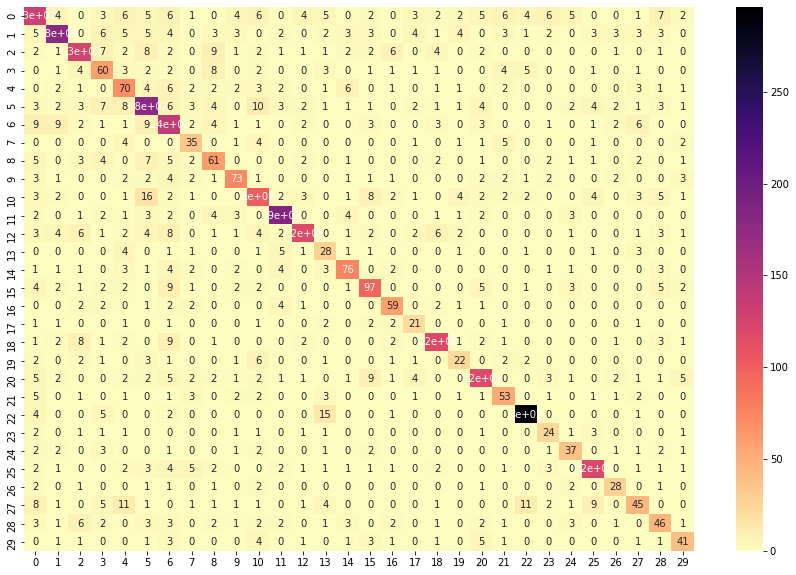

In [115]:
plt.figure(figsize=(15,10))
sns.heatmap(data=cm, cmap='magma_r', annot=True);

### Song2Vec

In [116]:
s2v_top_artist = s2v_df.merge(top_artist_songs, left_index=True, right_on='song_id')
assert len(top_artist_songs) == len(s2v_top_artist)
X_s2v = s2v_top_artist.drop(['song_id', 'label'], axis=1)
y_s2v = s2v_top_artist.label.values.astype(int)

In [117]:
X_train, X_test, y_train, y_test = \
                train_test_split(X_s2v, y_s2v, train_size=0.8, random_state=SEED)
(acc, f1_s2v, cm), std_s2v = predict_RF(X_train, X_test, y_train, y_test, param_grid=param_grid, scoring=scorer,multi=True)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END class_weight=balanced, criterion=gini, n_estimators=50; total time=  17.5s
[CV 2/5] END class_weight=balanced, criterion=gini, n_estimators=50; total time=  15.3s
[CV 3/5] END class_weight=balanced, criterion=gini, n_estimators=50; total time=  15.8s
[CV 4/5] END class_weight=balanced, criterion=gini, n_estimators=50; total time=  15.4s
[CV 5/5] END class_weight=balanced, criterion=gini, n_estimators=50; total time=  15.5s
[CV 1/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=  31.6s
[CV 2/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=  33.4s
[CV 3/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=  31.2s
[CV 4/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=  31.0s
[CV 5/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=  30.2s
[CV 1/5] END class_weight=balanced, criterion=gini, n_e

In [118]:
print("Song2Vec:", acc, f1_s2v)

Song2Vec: 0.18814968814968816 0.16904145311022636


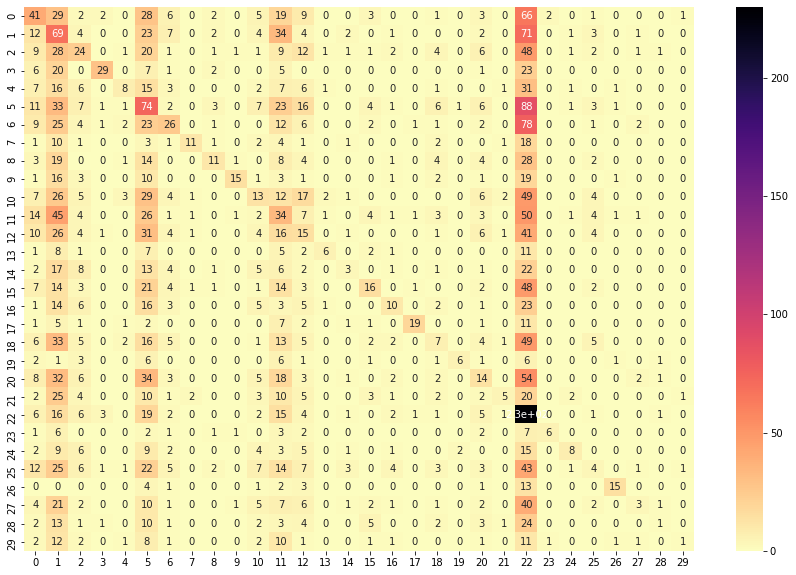

In [119]:
plt.figure(figsize=(15,10))
sns.heatmap(data=cm, cmap='magma_r', annot=True);

In [120]:
print("Random:", predict_random(X_train, y_train, X_test, y_test, multi=True)[:2])
print("Majority:",predict_majority(X_train, y_train, X_test, y_test, multi=True)[:2])

Random: (0.03144490644490645, 0.03418223129583527)
Majority: (0.08212058212058213, 0.012464026873248777)


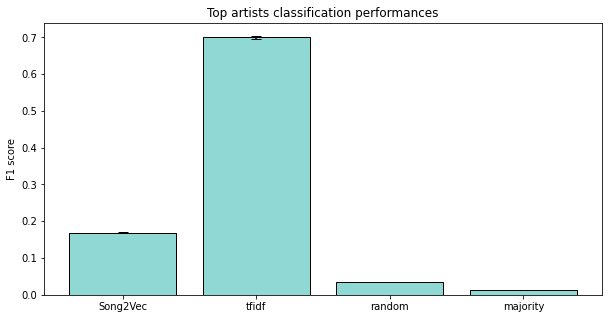

In [121]:
plot_metrics(f1_s2v, std_s2v, f1_tfidf, std_tfidf, "Top artists classification performances", multi=True)

## Top tag 

In [122]:
top_tags = pd.read_csv("data/song_tags_top1.csv")
songs = songs.merge(top_tags, how='left')

In [123]:
len(songs)

19098862

In [124]:
def create_top_tag_dataset(df, s2v_df, emb_vectors, tfidf_df, top_n=10):
    top_tags = list(df[df.song_id.isin(emb_vectors.keys())].tag_1.value_counts()\
        .to_frame().head(top_n).index)
    top_df = songs[songs.tag_1.isin(top_tags)].drop_duplicates('song_id').copy()
    mapping = {tag: top_tags.index(tag) for tag in top_tags}
    top_df['label'] = top_df.tag_1.map(mapping)
    top_df = top_df[['song_id', 'label']]
    top_df = top_df[top_df.song_id.isin(s2v_df.index) & top_df.song_id.isin(tfidf_df.index)]
    return top_df

In [125]:
top_tag_songs = create_top_tag_dataset(songs, s2v_df, emb_vectors, tfidf_df, top_n=10).iloc[:10000]
len(top_tag_songs)

10000

### TF-IDF

In [126]:
tfidf_top_tag = tfidf_df.merge(top_tag_songs, left_index=True, right_on='song_id')
assert len(top_tag_songs) == len(tfidf_top_tag)
X_tfidf = tfidf_top_tag.drop(['song_id', 'label'], axis=1)
y_tfidf = tfidf_top_tag.label.values.astype(int)

In [127]:
X_train, X_test, y_train, y_test = \
                train_test_split(X_tfidf, y_tfidf, train_size=0.8, random_state=SEED)

(acc, f1_tfidf, cm), std_tfidf = predict_RF(X_train, X_test, y_train, y_test, param_grid=param_grid, scoring=scorer, multi=True)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END class_weight=balanced, criterion=gini, n_estimators=50; total time=   2.8s
[CV 2/5] END class_weight=balanced, criterion=gini, n_estimators=50; total time=   2.7s
[CV 3/5] END class_weight=balanced, criterion=gini, n_estimators=50; total time=   2.6s
[CV 4/5] END class_weight=balanced, criterion=gini, n_estimators=50; total time=   2.6s
[CV 5/5] END class_weight=balanced, criterion=gini, n_estimators=50; total time=   3.0s
[CV 1/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=   5.3s
[CV 2/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=   5.7s
[CV 3/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=   5.0s
[CV 4/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=   5.2s
[CV 5/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=   4.9s
[CV 1/5] END class_weight=balanced, criterion=gini, n_e

In [128]:
print("TF-IDF:", acc, f1_tfidf)

TF-IDF: 0.7385 0.7251014635183162


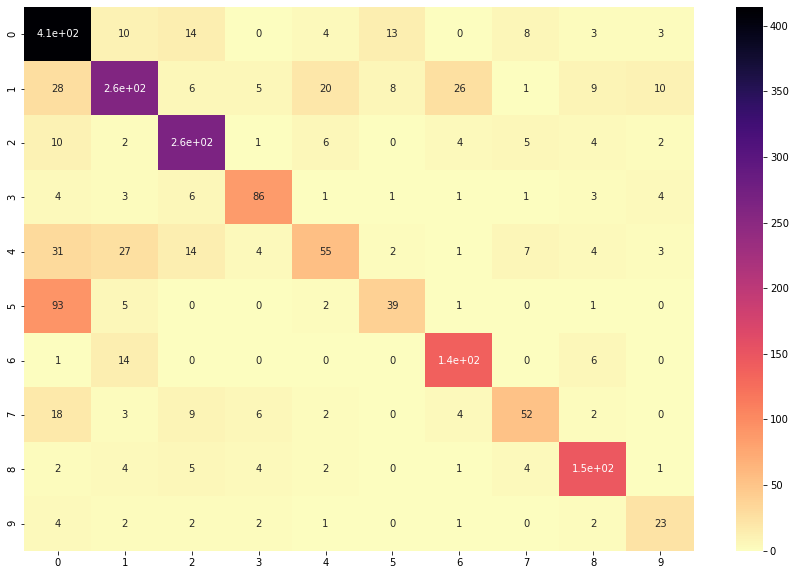

In [129]:
plt.figure(figsize=(15,10))
sns.heatmap(data=cm, cmap='magma_r', annot=True);

### Song2Vec

In [130]:
s2v_top_tag = s2v_df.merge(top_tag_songs, left_index=True, right_on='song_id')
assert len(top_tag_songs) == len(s2v_top_tag)
X_s2v = s2v_top_tag.drop(['song_id', 'label'], axis=1)
y_s2v = s2v_top_tag.label.values.astype(int)

In [131]:
X_train, X_test, y_train, y_test = \
                train_test_split(X_s2v, y_s2v, train_size=0.8, random_state=SEED)
(acc, f1_s2v, cm), std_s2v = predict_RF(X_train, X_test, y_train, y_test, param_grid=param_grid, scoring=scorer,multi=True)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END class_weight=balanced, criterion=gini, n_estimators=50; total time=   6.0s
[CV 2/5] END class_weight=balanced, criterion=gini, n_estimators=50; total time=   6.0s
[CV 3/5] END class_weight=balanced, criterion=gini, n_estimators=50; total time=   4.0s
[CV 4/5] END class_weight=balanced, criterion=gini, n_estimators=50; total time=   4.9s
[CV 5/5] END class_weight=balanced, criterion=gini, n_estimators=50; total time=   4.3s
[CV 1/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=   9.0s
[CV 2/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=   7.8s
[CV 3/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=   7.5s
[CV 4/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=   7.5s
[CV 5/5] END class_weight=balanced, criterion=gini, n_estimators=100; total time=   7.4s
[CV 1/5] END class_weight=balanced, criterion=gini, n_e

In [132]:
print("Song2Vec:", acc, f1_s2v)

Song2Vec: 0.27 0.22554839747264208


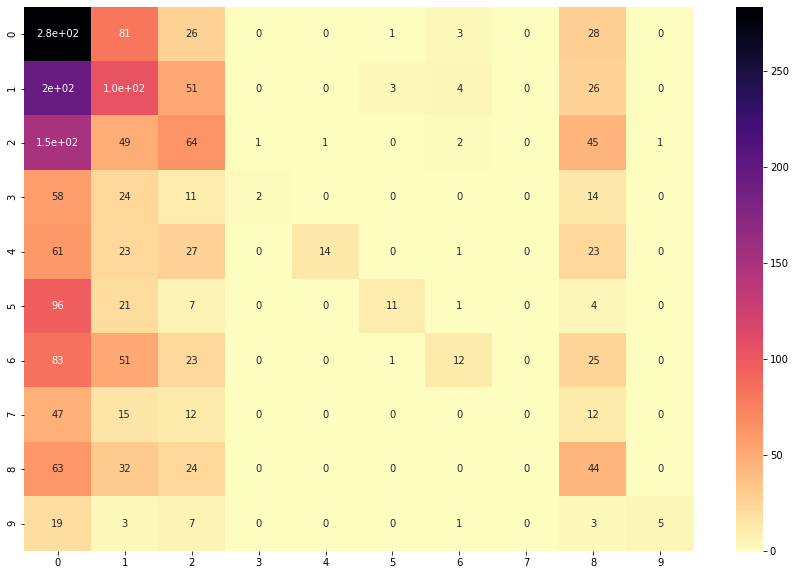

In [133]:
plt.figure(figsize=(15,10))
sns.heatmap(data=cm, cmap='magma_r', annot=True);

In [134]:
print("Random:", predict_random(X_train, y_train, X_test, y_test, multi=True)[:2])
print("Majority:",predict_majority(X_train, y_train, X_test, y_test, multi=True)[:2])

Random: (0.1, 0.10894689655114502)
Majority: (0.211, 0.07352766308835673)


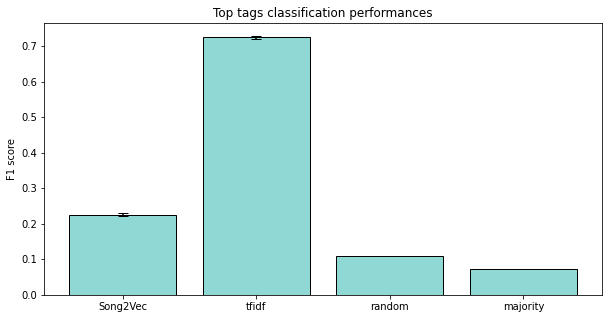

In [135]:
plot_metrics(f1_s2v, std_s2v, f1_tfidf, std_tfidf, "Top tags classification performances", multi=True)